# Preprocessing and packing

In [1]:
%matplotlib inline
import io
import os
import re
import time
import random
import functools
import itertools
from pathlib import Path
from collections import defaultdict
from typing import Tuple, Dict, Iterator, Optional, Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import natsort as ns
import tqdm.notebook as tqdm
import scipy.stats
import sklearn.metrics

import torch
from torch.utils.data import Dataset, Sampler
from torch.nn import (
    Module,
    Sequential,
    Linear,
    ReLU,
    Sigmoid,
    Embedding,
    ModuleDict,
    ModuleList,
    Dropout,
    BatchNorm1d,
    Identity,
)

import torch_sparse
import torch_scatter
import torch_geometric as tg
from torch_geometric.data import Data, Batch

from loguru import logger
from joblib import Parallel, delayed
from IPython.display import display, Markdown, HTML, Video

sns.set()

## Loading as a graph

In [2]:
class DecoyDataset(Dataset):
    def __init__(self, pth_paths, transforms=None):
        super().__init__()

        self.targets_by_target_id: Dict[str, Data] = {}
        self.targets_by_casp_ed_and_target_id: Dict[Tuple[int, str], Data] = {}
        self.decoys_by_target_id_and_decoy_id: Dict[Tuple[str, str], Data] = {}
        self.decoys_by_casp_ed_and_target_id_and_decoy_id: Dict[
            Tuple[int, str, str], Data
        ] = {}

        logger.info("Starting to load graphs")
        for p in pth_paths:
            target = torch.load(p)
            casp_ed = target["casp_ed"]
            target_id = target["target_id"]

            self.targets_by_target_id[target_id] = target
            self.targets_by_casp_ed_and_target_id[(casp_ed, target_id)] = target

            for decoy in target["graphs"]:
                decoy_id = decoy.decoy_id
                self.add_target_feats_to_decoy(target, decoy)
                self.decoys_by_target_id_and_decoy_id[(target_id, decoy_id)] = decoy
                self.decoys_by_casp_ed_and_target_id_and_decoy_id[
                    (casp_ed, target_id, decoy_id)
                ] = decoy

        if len(self) == 0:
            logger.warning("Empty dataset!")
        else:
            logger.info(f"Done loading {len(self)} graphs")
        self.transforms = transforms

    @staticmethod
    def add_target_feats_to_decoy(target: dict, decoy: Data):
        decoy.casp_ed = target["casp_ed"]
        decoy.target_id = target["target_id"]
        decoy.n_nodes = decoy.num_nodes
        decoy.n_edges = decoy.num_edges
        decoy.msa_feats = target["msa_feats"]
        decoy.aa = target["sequence"]

        if decoy.num_nodes == 0:
            # If a graph has 0 nodes and it's put last in the the batch formed by
            # Batch.from_data_list(...) it will cause a miscount in batch.num_graphs
            logger.warning(
                f"Found graph with 0 nodes: {decoy.casp_ed}/{decoy.target_id}/{decoy.decoy_id}"
            )

    def __getitem__(self, item):
        if isinstance(item, int):
            item = self.keys[item]
        *casp_ed, target_id, decoy_id = item
        graph = self.decoys_by_target_id_and_decoy_id[(target_id, decoy_id)]
        if self.transforms is not None:
            graph = self.transforms(graph.clone())
        return graph

    def __len__(self):
        return len(self.decoys_by_casp_ed_and_target_id_and_decoy_id)

    @functools.cached_property
    def casp_editions(self) -> Tuple[int]:
        return tuple(set(k[0] for k in self.targets_by_casp_ed_and_target_id.keys()))

    @functools.cached_property
    def target_ids(self) -> Tuple[str]:
        return tuple(self.targets_by_target_id.keys())

    @functools.cached_property
    def keys(self) -> Tuple[Tuple[int, str, str], ...]:
        return tuple(self.decoys_by_casp_ed_and_target_id_and_decoy_id.keys())


pth_files = Path().glob(f"CASP13/processed/*.pth")
ds = DecoyDataset(pth_files)

print(ds[0])
print(ds[1])
print(ds[2230])
print(ds[2231])

count = 0
for batch in tg.data.DataLoader(ds, batch_size=128):
    batch.debug()
    count += batch.num_graphs
print(count)

2020-04-11 14:31:10.866 | INFO     | __main__:__init__:12 - Starting to load graphs
2020-04-11 14:31:15.458 | INFO     | __main__:__init__:32 - Done loading 12852 graphs


Data(aa=[183], casp_ed=[1], decoy_id=3D-JIGSAW_SL1_TS1, edge_attr=[4328, 4], edge_index=[2, 4328], msa_feats=[183, 21], n_edges=[1], n_nodes=[1], qa_global=[1, 5], qa_local=[183, 2], secondary_structure=[183], target_id=T0949, x=[183, 3])
Data(aa=[183], casp_ed=[1], decoy_id=3D-JIGSAW_SL1_TS2, edge_attr=[4002, 4], edge_index=[2, 4002], msa_feats=[183, 21], n_edges=[1], n_nodes=[1], qa_global=[1, 5], qa_local=[183, 2], secondary_structure=[183], target_id=T0949, x=[183, 3])
Data(aa=[129], casp_ed=[1], decoy_id=MUFold_server_TS5, edge_attr=[3410, 4], edge_index=[2, 3410], msa_feats=[129, 21], n_edges=[1], n_nodes=[1], qa_global=[1, 5], qa_local=[129, 2], secondary_structure=[129], target_id=T1017s2, x=[129, 3])
Data(aa=[129], casp_ed=[1], decoy_id=MULTICOM-CONSTRUCT_TS1, edge_attr=[3164, 4], edge_index=[2, 3164], msa_feats=[129, 21], n_edges=[1], n_nodes=[1], qa_global=[1, 5], qa_local=[129, 2], secondary_structure=[129], target_id=T1017s2, x=[129, 3])
12852


## Graph Network

In [3]:
def round_to_pow2(value):
    return np.exp2(np.round(np.log2(value))).astype(int)


def layer_sizes_linear(in_feats, out_feats, layers, round_pow2=False):
    sizes = np.linspace(in_feats, out_feats, layers + 1).round().astype(np.int)
    if round_pow2:
        sizes[1:-1] = round_to_pow2(sizes[1:-1])
    return sizes.tolist()


def layer_sizes_exp2(in_feats, out_feats, layers, round_pow2=False):
    sizes = (
        np.logspace(np.log2(in_feats), np.log2(out_feats), layers + 1, base=2)
        .round()
        .astype(np.int)
    )
    if round_pow2:
        sizes[1:-1] = round_to_pow2(sizes[1:-1])
    return sizes.tolist()

In [4]:
class GraphQA(Module):
    def __init__(self):
        super().__init__()

        # Configuration
        aa_embedding_dim = 64
        ss_embedding_dim = 64
        sep_embedding_dim = 64
        rbf_num_bases = 16

        enc_out_node_feats = 128
        enc_out_edge_feats = 64

        mp_layers = 6
        mp_dropout = 0.2
        mp_batch_norm = False
        mp_in_edge_feats = enc_out_edge_feats + sep_embedding_dim + rbf_num_bases
        mp_in_node_feats = enc_out_node_feats + aa_embedding_dim + ss_embedding_dim
        mp_in_global_feats = 512
        mp_out_edge_feats = 16
        mp_out_node_feats = 64
        mp_out_global_feats = 32
        mp_edge_feats = layer_sizes_exp2(
            mp_in_edge_feats, mp_out_edge_feats, mp_layers, round_pow2=True
        )
        mp_node_feats = layer_sizes_exp2(
            mp_in_node_feats, mp_out_node_feats, mp_layers, round_pow2=True
        )
        mp_global_feats = layer_sizes_exp2(
            mp_in_global_feats, mp_out_global_feats, mp_layers, round_pow2=True
        )
        mp_sizes = zip(mp_edge_feats, mp_node_feats, [0] + mp_global_feats[1:])

        self.readout_concat = True

        # Embeddings (aa type, dssp classification, separation, distance)
        self.embeddings = ModuleDict(
            {
                "amino_acid": Embedding(
                    num_embeddings=20, embedding_dim=aa_embedding_dim
                ),
                "secondary_structure": Embedding(
                    num_embeddings=9, embedding_dim=ss_embedding_dim
                ),
                "separation": SeparationEmbedding(
                    bins=(1, 2, 3, 4, 5, 10, 15), embedding_dim=sep_embedding_dim
                ),
                "distance_rbf": RbfDistanceEncoding(
                    min_dist=0, max_dist=20, num_bases=rbf_num_bases
                ),
            }
        )

        # Encoder (dssp features on the nodes and geometric features on the edges)
        self.encoder = Encoder(
            out_edge_feats=enc_out_edge_feats, out_node_feats=enc_out_node_feats
        )

        # Message passing
        self.message_passing = ModuleList()
        in_e, in_n, in_g = next(mp_sizes)
        for out_e, out_n, out_g in mp_sizes:
            mp = MessagePassing(
                in_edge_feats=in_e,
                in_node_feats=in_n,
                in_global_feats=in_g,
                out_edge_feats=out_e,
                out_node_feats=out_n,
                out_global_feats=out_g,
                dropout=mp_dropout,
                batch_norm=mp_batch_norm,
            )
            self.message_passing.append(mp)
            in_e, in_n, in_g = out_e, out_n, out_g

        # Readout
        if self.readout_concat:
            in_n += mp_in_node_feats
        self.readout = Readout(in_n, in_g)

    @staticmethod
    def prepare(graphs: Batch) -> Tuple[torch.Tensor, ...]:
        aa = graphs.aa
        msa_feats = graphs.msa_feats
        x = graphs.x
        edge_index = graphs.edge_index
        edge_attr = graphs.edge_attr
        secondary_structure = graphs.secondary_structure
        batch = graphs.batch

        return aa, msa_feats, x, edge_index, edge_attr, secondary_structure, batch

    def forward(
        self, aa, msa_feats, x, edge_index, edge_attr, secondary_structure, batch
    ):
        # Embeddings (aa type, dssp classification, separation, distance)
        aa = self.embeddings.amino_acid(aa.long())
        ss = self.embeddings.secondary_structure(secondary_structure.long())
        sep = self.embeddings.separation(edge_index)
        rbf = self.embeddings.distance_rbf(edge_attr[:, 0])

        # Encoder (dssp features on the nodes and geometric features on the edges)
        x, edge_attr = self.encoder(x, msa_feats, edge_attr)

        # Message passing
        x = x_mp = torch.cat((aa, x, ss), dim=1)
        edge_attr = torch.cat((edge_attr, sep, rbf), dim=1)
        num_graphs = batch[-1].item() + 1
        u = torch.empty(num_graphs, 0, dtype=torch.float, device=x.device)
        for mp in self.message_passing:
            x, edge_attr, edge_index, u, batch = mp(x, edge_attr, edge_index, u, batch)

        # Readout
        if self.readout_concat:
            x = torch.cat((x, x_mp), dim=1)
        x, u = self.readout(x, u)
        return x, u


class SeparationEmbedding(Module):
    def __init__(self, embedding_dim, bins: tuple):
        super().__init__()
        self.bins = bins
        self.emb = Embedding(num_embeddings=len(bins) + 1, embedding_dim=embedding_dim)

    @torch.jit.ignore
    def _sep_to_code(self, separation):
        codes = np.digitize(separation.abs().cpu().numpy(), bins=self.bins, right=True)
        codes = torch.from_numpy(codes).to(separation.device)
        return codes

    def forward(self, edge_index):
        separation = edge_index[0] - edge_index[1]
        codes = self._sep_to_code(separation)
        embeddings = self.emb(codes)
        return embeddings


class RbfDistanceEncoding(Module):
    def __init__(self, min_dist: float, max_dist: float, num_bases: int):
        super().__init__()
        if not 0 <= min_dist < max_dist:
            raise ValueError(
                f"Invalid RBF centers: 0 <= {min_dist} < {max_dist} is False"
            )
        if num_bases < 0:
            raise ValueError(f"Invalid RBF size: 0 < {num_bases} is False")
        self.register_buffer(
            "rbf_centers", torch.linspace(min_dist, max_dist, steps=num_bases)
        )

    def forward(self, distances):
        # assert distances.ndim == 1
        # Distances are encoded using a equally spaced RBF kernels with unit variance
        rbf = torch.exp(-((distances[:, None] - self.rbf_centers[None, :]) ** 2))
        return rbf

    def extra_repr(self):
        return f"bases={len(self.rbf_centers)}"


class Encoder(Module):
    def __init__(self, out_edge_feats, out_node_feats):
        super().__init__()
        self.node_encoder = Sequential(
            Linear(3 + 21, out_node_feats // 2),
            ReLU(),
            Linear(out_node_feats // 2, out_node_feats),
            ReLU(),
        )
        self.edge_encoder = Sequential(
            Linear(4, out_edge_feats // 2),
            ReLU(),
            Linear(out_edge_feats // 2, out_edge_feats),
            ReLU(),
        )

    def forward(self, x, msa_feats, edge_attr):
        x = self.node_encoder(torch.cat((x, msa_feats), dim=1))
        edge_attr = self.edge_encoder(edge_attr)
        return x, edge_attr


class MessagePassing(Module):
    def __init__(
        self,
        in_edge_feats: int,
        in_node_feats: int,
        in_global_feats: int,
        out_edge_feats: int,
        out_node_feats: int,
        out_global_feats: int,
        batch_norm: bool,
        dropout: float,
    ):
        super().__init__()
        in_feats = in_node_feats + in_edge_feats + in_global_feats
        self.edge_fn = Sequential(
            Linear(in_feats, out_edge_feats),
            Dropout(p=dropout) if dropout > 0 else Identity(),
            BatchNorm1d(out_edge_feats) if batch_norm else Identity(),
            ReLU(),
        )
        in_feats = in_node_feats + out_edge_feats + in_global_feats
        self.node_fn = Sequential(
            Linear(in_feats, out_node_feats),
            Dropout(p=dropout) if dropout > 0 else Identity(),
            BatchNorm1d(out_node_feats) if batch_norm else Identity(),
            ReLU(),
        )
        in_feats = out_node_feats + out_edge_feats + in_global_feats
        self.global_fn = Sequential(
            Linear(in_feats, out_global_feats),
            Dropout(p=dropout) if dropout > 0 else Identity(),
            BatchNorm1d(out_global_feats) if batch_norm else Identity(),
            ReLU(),
        )

    def forward(self, x, edge_attr, edge_index, u, batch):
        x_src = x[edge_index[0]]
        u_src = u[batch[edge_index[0]]]
        edge_attr = torch.cat((x_src, edge_attr, u_src), dim=1)
        edge_attr = self.edge_fn(edge_attr)

        msg_to_node = torch_scatter.scatter(
            edge_attr, edge_index[1], dim=0, dim_size=x.shape[0], reduce="mean"
        )
        u_to_node = u[batch]
        x = torch.cat((x, msg_to_node, u_to_node), dim=1)
        x = self.node_fn(x)

        edge_global = torch_scatter.scatter(
            edge_attr, batch[edge_index[0]], dim=0, dim_size=u.shape[0], reduce="mean"
        )
        x_global = torch_scatter.scatter(
            x, batch, dim=0, dim_size=u.shape[0], reduce="mean"
        )
        u = torch.cat((edge_global, x_global, u), dim=1)
        u = self.global_fn(u)

        return x, edge_attr, edge_index, u, batch


class Readout(Module):
    def __init__(self, in_node_feats, in_global_feats):
        super().__init__()
        self.node_fn = Sequential(Linear(in_node_feats, 2), Sigmoid())
        self.global_fn = Sequential(Linear(in_global_feats, 5), Sigmoid())

    def forward(self, x, u):
        x = self.node_fn(x)
        u = self.global_fn(u)
        return x, u


batch = Batch.from_data_list([ds[i] for i in [15, 84, 5984, 45]])
print(f"\nInput graphs:\nnodes: {batch.num_nodes}\ngraphs: {batch.num_graphs}")

print("\nTiming without jit")
model = GraphQA()
%timeit x, u = model(*GraphQA.prepare(batch))

print("\nTiming with jit")
model = GraphQA()
model = torch.jit.script(model)
%timeit x, u = model(*GraphQA.prepare(batch))

x, u = model(*GraphQA.prepare(batch))
print(f"\nOutput shapes:\nx: {tuple(x.shape)}\nu: {tuple(u.shape)}")


Input graphs:
nodes: 621
graphs: 4

Timing without jit
223 ms ± 74.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing with jit
209 ms ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Output shapes:
x: (621, 2)
u: (4, 5)


## Training

In [5]:
class RandomTargetSampler(Sampler):
    def __init__(self, dataset: DecoyDataset, rg: np.random.Generator):
        super().__init__(dataset)
        self.rg = rg
        self.target_ids = dataset.target_ids
        self.decoys_by_target = defaultdict(list)
        for casp_ed, target_id, decoy_id in dataset.keys:
            self.decoys_by_target[target_id].append((casp_ed, target_id, decoy_id))
        assert len(self.decoys_by_target) == len(self.target_ids)

    def __iter__(self):
        target_ids = self.rg.permutation(self.target_ids)
        for target_id in target_ids:
            decoys_list = self.decoys_by_target[target_id]
            yield self.rg.choice(decoys_list)

    def __len__(self):
        return len(self.decoys_by_target)

In [6]:
@torch.jit.script
def nan_mse(input, target):
    mask = torch.isfinite(target)
    zero = target.new_zeros(())
    num = torch.where(mask, target - input, zero).pow(2).sum(dim=0)
    den = mask.sum(dim=0)
    return num / den

2020-04-11 14:31:29.240 | INFO     | __main__:__init__:12 - Starting to load graphs
2020-04-11 14:31:56.939 | INFO     | __main__:__init__:32 - Done loading 73165 graphs
2020-04-11 14:32:00.199 | INFO     | __main__:<module>:32 - [0 min] Starting 200 epochs
2020-04-11 14:34:01.795 | INFO     | __main__:<module>:74 - [2.0 min] Done epoch 37/200
2020-04-11 14:36:02.719 | INFO     | __main__:<module>:74 - [4.0 min] Done epoch 75/200
2020-04-11 14:38:03.551 | INFO     | __main__:<module>:74 - [6.1 min] Done epoch 113/200
2020-04-11 14:40:04.714 | INFO     | __main__:<module>:74 - [8.1 min] Done epoch 151/200
2020-04-11 14:42:05.401 | INFO     | __main__:<module>:74 - [10.1 min] Done epoch 189/200
2020-04-11 14:42:39.977 | INFO     | __main__:<module>:74 - [10.7 min] Done epoch 200/200


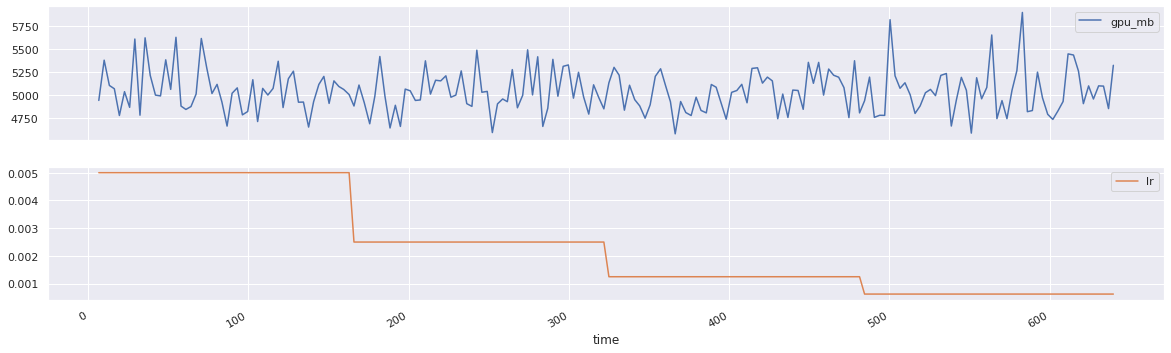

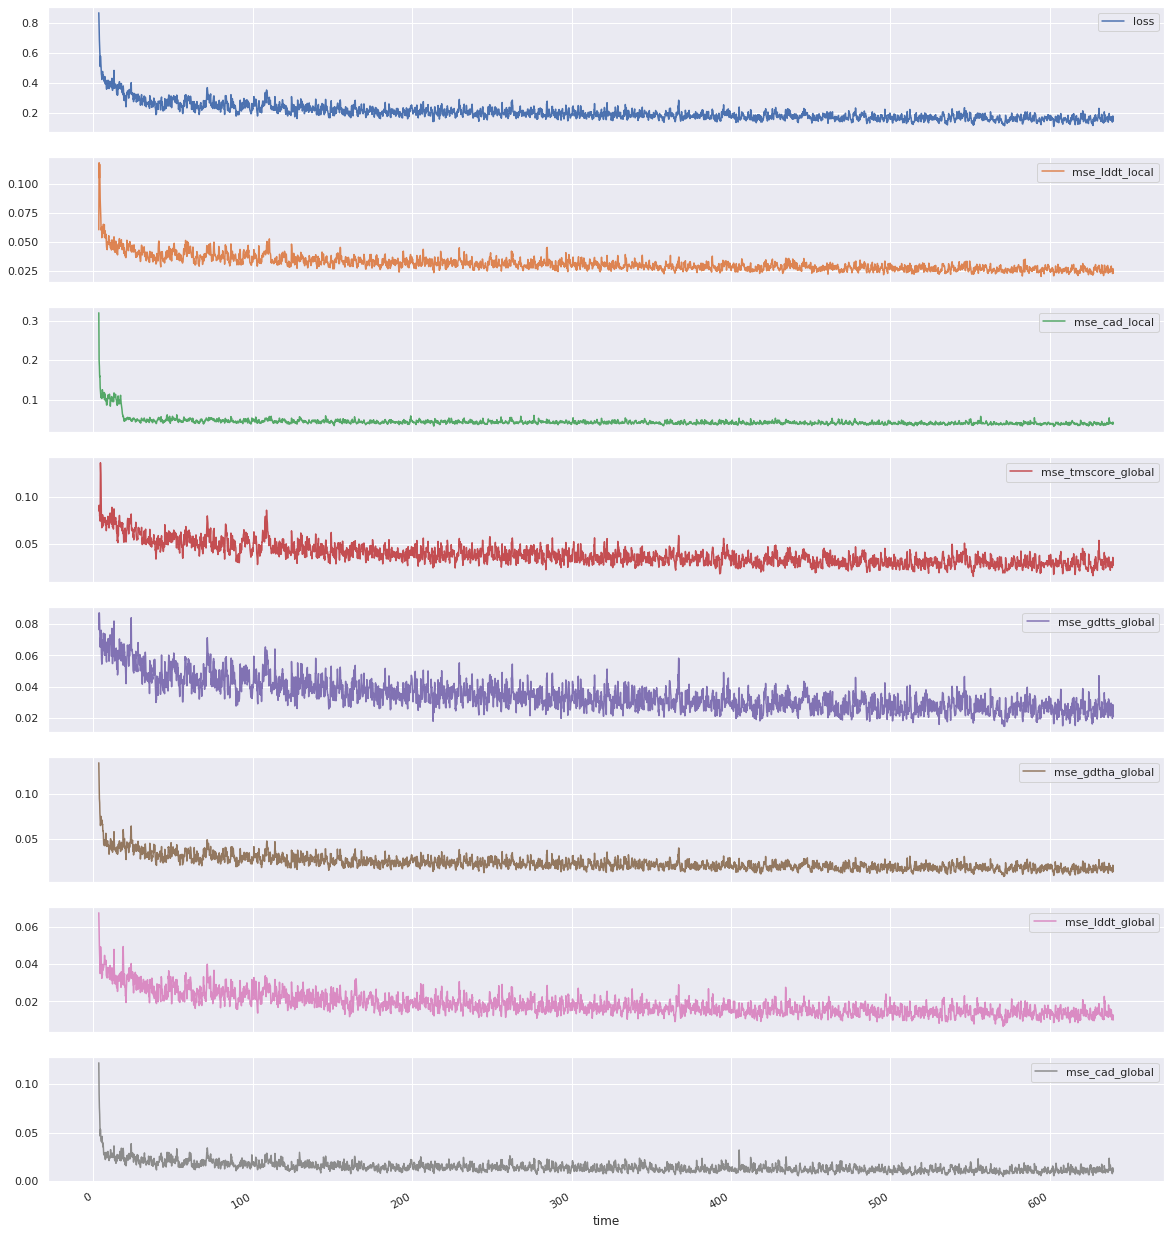

In [7]:
# Data
ds = DecoyDataset(
    itertools.chain(
        *(Path().glob(f"CASP{casp_ed}/processed/*.pth") for casp_ed in [9, 10, 11, 12])
    )
)
dl = tg.data.DataLoader(
    ds,
    batch_size=16,
    sampler=RandomTargetSampler(ds, np.random.default_rng(42)),
    drop_last=True,
)

# Model and optimizers
device = torch.device("cuda:1")
model = GraphQA()
model.to(device)
model.train()
model = torch.jit.script(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 50, gamma=0.5)

# Training loop
max_epochs = 200
weight_local = 1.0
weight_global = 1.0

start = time.time()
last = start
scores_epoch = []
scores_batch = []
logger.info(f"[0 min] Starting {max_epochs} epochs")

for epoch in range(1, max_epochs + 1):
    torch.cuda.reset_peak_memory_stats(device)

    for batch in dl:
        batch.to(device)
        x, u = model(*GraphQA.prepare(batch))

        mse_local = nan_mse(x, batch.qa_local)
        mse_global = nan_mse(u, batch.qa_global)
        loss = (weight_local * mse_local).sum() + (weight_global * mse_global).sum()

        model.zero_grad()
        loss.backward()
        optimizer.step()

        scores_batch.append(
            {
                "time": time.time() - start,
                "loss": loss.item(),
                "mse_lddt_local": mse_local[0].item(),
                "mse_cad_local": mse_local[1].item(),
                "mse_tmscore_global": mse_global[0].item(),
                "mse_gdtts_global": mse_global[1].item(),
                "mse_gdtha_global": mse_global[2].item(),
                "mse_lddt_global": mse_global[3].item(),
                "mse_cad_global": mse_global[4].item(),
            }
        )

    now = time.time()
    scores_epoch.append(
        {
            "time": now - start,
            "gpu_mb": torch.cuda.max_memory_allocated(device) / 2 ** 20,
            "lr": optimizer.param_groups[0]["lr"],
        }
    )
    scheduler.step()
    if now - last > 120 or epoch == max_epochs:
        last = now
        logger.info(f"[{(now - start)/60:.1f} min] Done epoch {epoch}/{max_epochs}")

scores_epoch = pd.DataFrame(scores_epoch).set_index("time")
# scores_epoch.index = pd.to_timedelta(metrics.index, unit="s")
scores_epoch.plot(
    subplots=True, figsize=(20, 3 * len(scores_epoch.columns)), sharex=True
)

scores_batch = pd.DataFrame(scores_batch).set_index("time")
scores_batch.ewm(alpha=0.4).mean().plot(
    subplots=True, figsize=(20, 3 * len(scores_batch.columns)), sharex=True
)

del (
    scores_epoch,
    scores_batch,
    ds,
    dl,
    optimizer,
    scheduler,
    loss,
    mse_local,
    mse_global,
)

## Evaluation

In [8]:
model.eval()
torch.set_grad_enabled(False)
ds = DecoyDataset(Path().glob(f"CASP13/processed/*.pth"))
dl = tg.data.DataLoader(ds, batch_size=32, drop_last=False)

scores_local = defaultdict(list)
scores_global = defaultdict(list)

for batch in dl:
    batch.to(device)
    x, u = model(*GraphQA.prepare(batch))

    scores_global["target_id"] += batch.target_id
    scores_global["decoy_id"] += batch.decoy_id
    scores_global[("tm", "true")].append(batch.qa_global[:, 0].cpu().numpy())
    scores_global[("tm", "pred")].append(u[:, 0].cpu().numpy())
    scores_global[("gdtts", "true")].append(batch.qa_global[:, 1].cpu().numpy())
    scores_global[("gdtts", "pred")].append(u[:, 1].cpu().numpy())
    scores_global[("gdtha", "true")].append(batch.qa_global[:, 2].cpu().numpy())
    scores_global[("gdtha", "pred")].append(u[:, 2].cpu().numpy())
    scores_global[("lddt", "true")].append(batch.qa_global[:, 3].cpu().numpy())
    scores_global[("lddt", "pred")].append(u[:, 3].cpu().numpy())
    scores_global[("cad", "true")].append(batch.qa_global[:, 4].cpu().numpy())
    scores_global[("cad", "pred")].append(u[:, 4].cpu().numpy())

    scores_local["target_id"].append(
        np.array(batch.target_id).repeat(batch.n_nodes.cpu().numpy())
    )
    scores_local["decoy_id"].append(
        np.array(batch.decoy_id).repeat(batch.n_nodes.cpu().numpy())
    )
    scores_local[("lddt", "true")].append(batch.qa_local[:, 0].cpu().numpy())
    scores_local[("lddt", "pred")].append(x[:, 0].cpu().numpy())
    scores_local[("cad", "true")].append(batch.qa_local[:, 1].cpu().numpy())
    scores_local[("cad", "pred")].append(x[:, 1].cpu().numpy())

scores_global = (
    pd.DataFrame(
        {
            k: np.concatenate(v)
            for k, v in scores_global.items()
            if isinstance(k, tuple)
        },
        index=pd.MultiIndex.from_arrays(
            [v for k, v in scores_global.items() if not isinstance(k, tuple)],
            names=[k for k, v in scores_global.items() if not isinstance(k, tuple)],
        ),
    )
    .rename_axis(columns=["score", None])
    .sort_index()
)
display(scores_global)

scores_local = (
    pd.DataFrame(
        {k: np.concatenate(v) for k, v in scores_local.items() if isinstance(k, tuple)},
        index=pd.MultiIndex.from_arrays(
            [
                np.concatenate(v)
                for k, v in scores_local.items()
                if not isinstance(k, tuple)
            ],
            names=[k for k, v in scores_local.items() if not isinstance(k, tuple)],
        ),
    )
    .rename_axis(columns=["score", None])
    .sort_index()
)
display(scores_local)

2020-04-11 14:42:45.039 | INFO     | __main__:__init__:12 - Starting to load graphs
2020-04-11 14:42:48.663 | INFO     | __main__:__init__:32 - Done loading 12852 graphs


score                            tm             gdtts             gdtha  \
                               true      pred    true      pred    true   
target_id decoy_id                                                        
T0949     3D-JIGSAW_SL1_TS1  0.2183  0.273542  0.1725  0.213338  0.0891   
          3D-JIGSAW_SL1_TS2  0.2542  0.246206  0.1996  0.188368  0.0988   
          3D-JIGSAW_SL1_TS3  0.2254  0.273677  0.1725  0.213464  0.0930   
          3D-JIGSAW_SL1_TS4  0.2341  0.320358  0.1938  0.257504  0.1027   
          3D-JIGSAW_SL1_TS5  0.1849  0.292805  0.1453  0.231303  0.0795   
...                             ...       ...     ...       ...     ...   
T1022s2   slbio_server_TS1   0.7287  0.573088  0.4618  0.499031  0.2723   
          slbio_server_TS2   0.6896  0.604041  0.4514  0.526268  0.2743   
          slbio_server_TS3   0.6910  0.530056  0.4216  0.461419  0.2431   
          slbio_server_TS4   0.7110  0.581150  0.4598  0.506163  0.2763   
          slbio_server_TS5   0.6722  0.554497  0.4177  0.482628  0.2436   

score                                      lddt                 cad            
                                 pred      true      pred      true      pred  
target_id decoy_id                                                             
T0949     3D-JIGSAW_SL1_TS1  0.128436  0.201359  0.281212  0.137061  0.182092  
          3D-JIGSAW_SL1_TS2  0.110978  0.192465  0.259949  0.150832  0.165877  
          3D-JIGSAW_SL1_TS3  0.128526  0.178351  0.281318  0.117329  0.182174  
          3D-JIGSAW_SL1_TS4  0.160739  0.181011  0.316866  0.137842  0.210169  
          3D-JIGSAW_SL1_TS5  0.141359  0.151867  0.295987  0.105210  0.193589  
...                               ...       ...       ...       ...       ...  
T1022s2   slbio_server_TS1   0.353950  0.490726  0.489707  0.354444  0.353097  
          slbio_server_TS2   0.375582  0.490918  0.508030  0.377907  0.367902  
          slbio_server_TS3   0.325113  0.493189  0.464300  0.365197  0.333071  
          slbio_server_TS4   0.359607  0.491463  0.494510  0.366814  0.356980  
          slbio_server_TS5   0.341192  0.489777  0.478630  0.366985  0.344277  

[12852 rows x 10 columns]

score                            lddt                 cad          
                                 true      pred      true      pred
target_id decoy_id                                                 
T0949     3D-JIGSAW_SL1_TS1       NaN  0.191548       NaN  0.101988
          3D-JIGSAW_SL1_TS1       NaN  0.306996       NaN  0.213518
          3D-JIGSAW_SL1_TS1       NaN  0.288262       NaN  0.182646
          3D-JIGSAW_SL1_TS1       NaN  0.257568       NaN  0.155506
          3D-JIGSAW_SL1_TS1       NaN  0.256661       NaN  0.163521
...                               ...       ...       ...       ...
T1022s2   slbio_server_TS5   0.359274  0.421789  0.200499  0.296736
          slbio_server_TS5   0.433784  0.421022  0.533363  0.301664
          slbio_server_TS5   0.322984  0.406622  0.227340  0.269772
          slbio_server_TS5        NaN  0.420880       NaN  0.284677
          slbio_server_TS5        NaN  0.386823       NaN  0.244612

[3024161 rows x 4 columns]

In [9]:
def rmse(preds, true):
    return np.sqrt(sklearn.metrics.mean_squared_error(preds, true))


def r2_score(preds, true):
    return sklearn.metrics.r2_score(true, preds)


def pearson(preds, true):
    return scipy.stats.pearsonr(preds, true)[0]


def spearmanr(preds, true):
    return scipy.stats.spearmanr(preds, true)[0]


def kendalltau(preds, true):
    return scipy.stats.kendalltau(preds, true)[0]


def first_rank_loss(preds, true):
    return true.max() - true.iloc[preds.argmax()]


def per_score_metrics(df_score: pd.DataFrame):
    df = df_score.droplevel(axis=1, level="score")
    df = df.dropna(axis="index", subset=["true"])
    pred = df["pred"]
    true = df["true"]
    return pd.Series(
        {
            "RMSE": rmse(pred, true),
            "R2": r2_score(pred, true),
            "R": pearson(pred, true),
            "ρ": spearmanr(pred, true),
            "τ": kendalltau(pred, true),
            "FRL": first_rank_loss(pred, true),
        }
    )


def compute_global_metrics(df_target: pd.DataFrame):
    return (
        df_target.groupby(axis=1, level="score")
        .apply(per_score_metrics)
        .rename_axis(index="metric")
    )


def compute_local_metrics(df_decoy: pd.DataFrame):
    return (
        df_decoy.groupby(axis=1, level="score")
        .apply(per_score_metrics)
        .rename_axis(index="metric")
    )


def groupby_apply(df, by, fn, *, n_jobs=-1, verbose=0):
    if not isinstance(by, (tuple, list)):
        by = [by]

    def wrapper(g: tuple):
        group_key = g[0]
        group_df = g[1]
        return group_key, fn(group_df)

    with Parallel(n_jobs=n_jobs, verbose=verbose) as pool:
        result = pool(delayed(wrapper)(g) for g in df.groupby(by))
    result = pd.concat([r[1] for r in result], keys=[r[0] for r in result], names=by)
    return result

In [10]:
# Parallel apply for global metrics
%timeit scores_global.groupby("target_id").apply(compute_global_metrics)
%timeit groupby_apply(scores_global, 'target_id', compute_global_metrics, n_jobs=10)
pd.testing.assert_frame_equal(
    scores_global.groupby("target_id").apply(compute_global_metrics),
    groupby_apply(scores_global, "target_id", compute_global_metrics, n_jobs=10),
)

# Parallel apply for local metrics
%timeit -n1 -r1 scores_local.groupby(["target_id", "decoy_id"]).apply(compute_local_metrics)
%timeit -n1 -r1 groupby_apply(scores_local, ["target_id", "decoy_id"], compute_local_metrics, n_jobs=10)
pd.testing.assert_frame_equal(
    scores_local.groupby(["target_id", "decoy_id"]).apply(compute_local_metrics),
    groupby_apply(
        scores_local, ["target_id", "decoy_id"], compute_local_metrics, n_jobs=10
    ),
)

2.79 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.1 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
# Global metrics
display(
    pd.concat(
        (
            compute_global_metrics(scores_global),
            groupby_apply(scores_global, "target_id", compute_global_metrics, n_jobs=10)
            .groupby("metric")
            .mean(),
        ),
        keys=["Across all targets", "Averaged per target"],
    )
)

# Local metrics
display(
    pd.concat(
        (
            compute_local_metrics(scores_local),
            groupby_apply(
                scores_local,
                ["target_id", "decoy_id"],
                compute_local_metrics,
                n_jobs=10,
            )
            .groupby("metric")
            .mean(),
        ),
        keys=["Across all decoys", "Averaged per decoy"],
    )
)

score                            cad     gdtha     gdtts      lddt        tm
                    metric                                                  
Across all targets  RMSE    0.111123  0.142388  0.174420  0.130483  0.182042
                    R2      0.436004  0.465411  0.483998  0.464466  0.491245
                    R       0.684148  0.683826  0.696985  0.688618  0.701897
                    ρ       0.696168  0.688730  0.689276  0.688910  0.699177
                    τ       0.501799  0.494596  0.495579  0.495575  0.505688
                    FRL     0.380606  0.438300  0.293900  0.338924  0.264100
Averaged per target RMSE    0.100544  0.131052  0.165535  0.121402  0.175362
                    R2     -0.555939 -2.515058 -1.815881 -1.195145 -1.783057
                    R       0.593083  0.570483  0.573645  0.607468  0.560854
                    ρ       0.560194  0.537181  0.542341  0.576540  0.532569
                    τ       0.409323  0.386747  0.390538  0.420426  0.381114
                    FRL     0.113032  0.119744  0.135831  0.109471  0.144083

score                           cad      lddt
                   metric                    
Across all decoys  RMSE    0.202187  0.168462
                   R2      0.250815  0.406199
                   R       0.520021  0.645782
                   ρ       0.522372  0.642436
                   τ       0.359686  0.453151
                   FRL     0.659813  0.471707
Averaged per decoy RMSE    0.196852  0.155228
                   R2     -0.221915 -1.253852
                   R       0.264872  0.348567
                   ρ       0.262050  0.332904
                   τ       0.179352  0.229681
                   FRL     0.421559  0.195061

## Plots

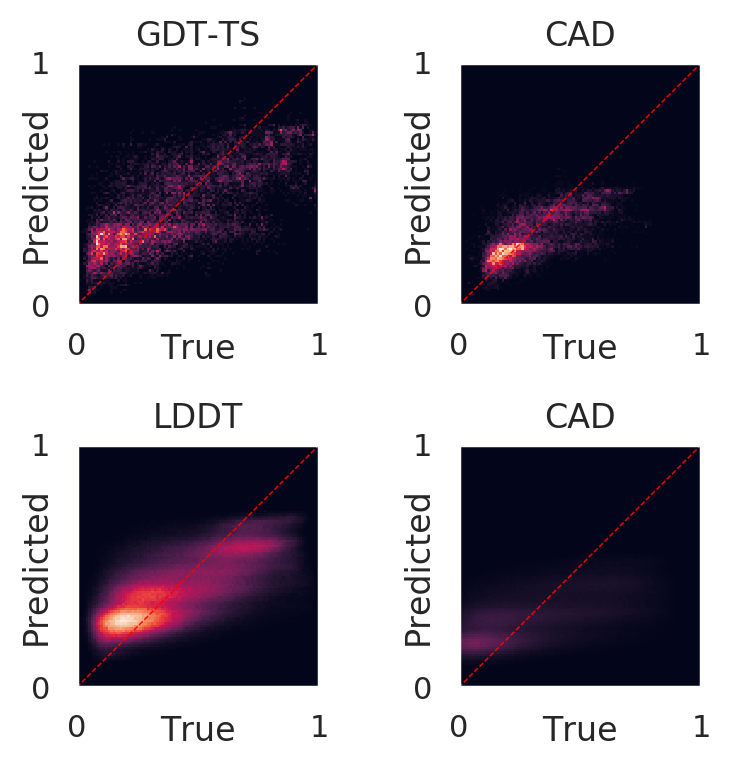

In [12]:
plots = [
    ("GDT-TS", scores_global["gdtts"]["true"], scores_global["gdtts"]["pred"]),
    ("CAD", scores_global["cad"]["true"], scores_global["cad"]["pred"]),
    ("LDDT", scores_local["lddt"]["true"], scores_local["lddt"]["pred"]),
    ("CAD", scores_local["cad"]["true"], scores_local["cad"]["pred"]),
]


def histogram(ax, title, true, preds):
    bins = np.linspace(0, 1, 100 + 1)
    hist, _, _ = np.histogram2d(true, preds, bins=bins)
    ax.pcolormesh(bins, bins, hist.T, zorder=1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels(["0", "", "", "", "", "1"])
    ax.set_title(title)
    ax.set_xlabel(f"True", labelpad=-10)
    ax.set_ylabel("Predicted")
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0", "", "", "", "", "1"])
    ax.set_ylabel("Predicted", labelpad=-8)
    ax.plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=0.5, zorder=2)


fig, axes = plt.subplots(2, 2, figsize=(4, 4), dpi=200)
for ax, (title, true, preds) in zip(axes.flat, plots):
    histogram(ax, title, true, preds)

fig.tight_layout()
fig.set_facecolor("white")
display(fig)
plt.close(fig)

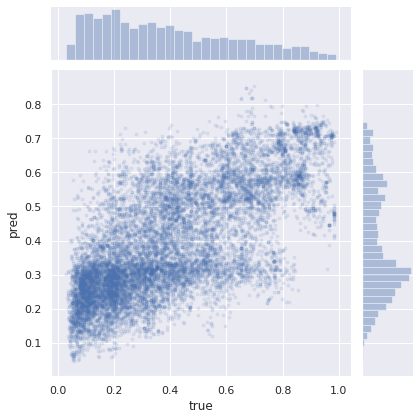

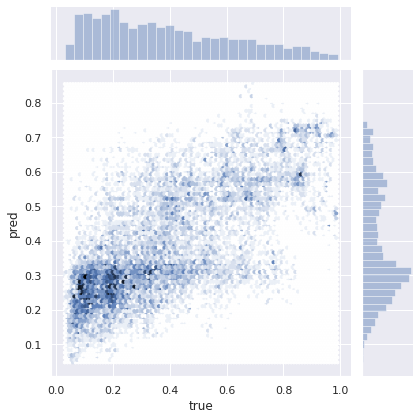

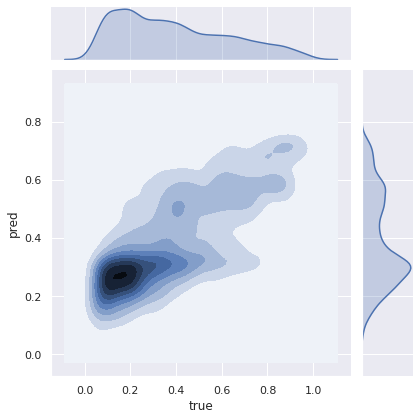

In [13]:
sns.jointplot(
    x="true",
    y="pred",
    data=scores_global["gdtts"],
    kind="scatter",
    alpha=0.1,
    marker=".",
)
sns.jointplot(x="true", y="pred", data=scores_global["gdtts"], kind="hex", gridsize=100)
sns.jointplot(x="true", y="pred", data=scores_global["gdtts"], kind="kde", gridsize=100)

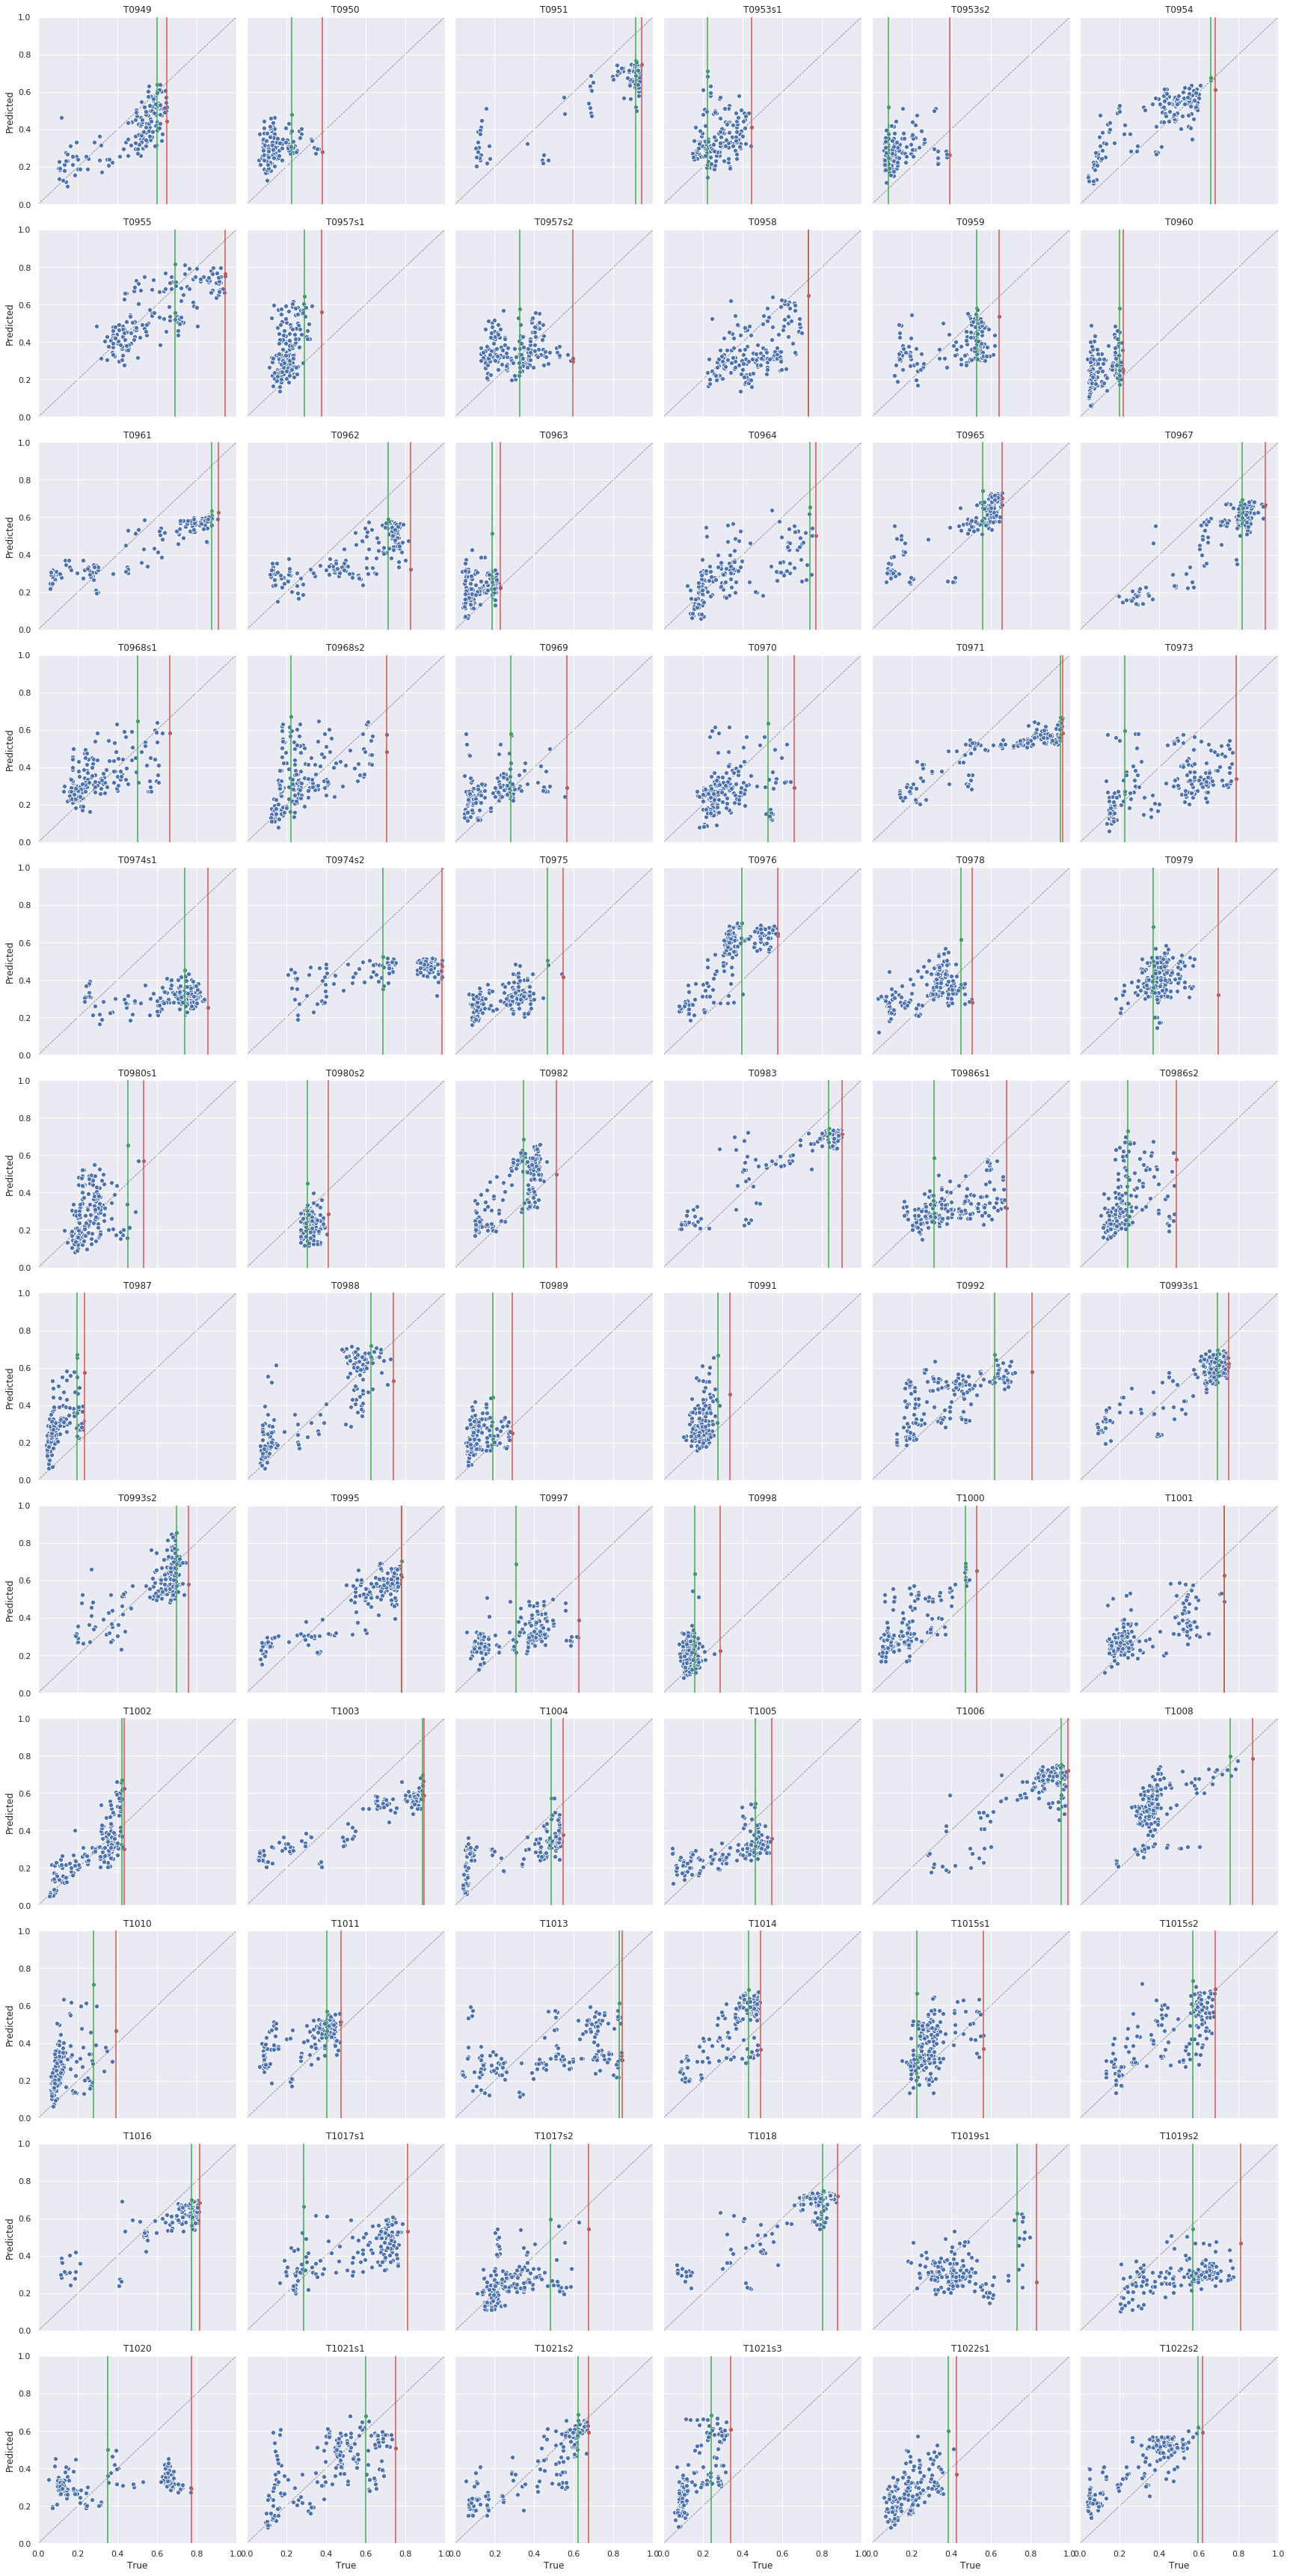

In [14]:
facetgrid = sns.relplot(
    x="true",
    y="pred",
    data=scores_global["gdtts"].reset_index(),
    col="target_id",
    col_wrap=6,
    height=4,
    aspect=1.0,
)


def draw_best(true, pred, **kwargs):
    best_predicted = pred.argmax()
    plt.axvline(
        true.iloc[best_predicted],
        c=sns.xkcd_rgb["medium green"],
        linewidth=1.5,
        zorder=20,
    )
    plt.scatter(
        true.iloc[best_predicted],
        pred.iloc[best_predicted],
        c=sns.xkcd_rgb["medium green"],
        s=42,
        marker=".",
        zorder=21,
    )

    best_true = true.argmax()
    plt.axvline(
        true.iloc[best_true], c=sns.xkcd_rgb["pale red"], linewidth=1.5, zorder=30
    )
    plt.scatter(
        true.iloc[best_true],
        pred.iloc[best_true],
        c=sns.xkcd_rgb["pale red"],
        s=42,
        marker=".",
        zorder=31,
    )


facetgrid.map(draw_best, "true", "pred")
facetgrid.set_titles("{col_name}")
facetgrid.set_xlabels("True")
facetgrid.set_ylabels("Predicted")

for ax in facetgrid.axes:
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=0.8, zorder=0)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)